# Import Statements

In [ ]:
import imgaug.augmenters as iaa
import nibabel as nib
from google.colab import drive
from sklearn.model_selection import train_test_split
import os
import os
import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('dark_background')
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score

# One Hot Encoding the Target Classes

In [ ]:
drive.mount('/content/drive')
dataset_path = '/content/drive/My Drive/MRI_IMAGES/brain_tumor_dataset/'

Mounted at /content/drive


In [ ]:
encoder = OneHotEncoder()
encoder.fit([[0], [1]])

# 0 - Tumor
# 1 - Normal

OneHotEncoder()

AUGMENTATION

In [ ]:
# define the augmentation sequence
augmenter = iaa.Sequential([
    iaa.GaussianBlur(sigma=(0, 3.0)),
    iaa.AdditiveGaussianNoise(scale=(0, 0.05*255)),
    iaa.Affine(rotate=(-20, 20), shear=(-5, 5))
])

In [ ]:
# specify the path to your input folders
input_path_yes = '/content/drive/My Drive/MRI_IMAGES/brain_tumor_dataset/yes'
input_path_no = '/content/drive/My Drive/MRI_IMAGES/brain_tumor_dataset/no'

In [ ]:
# loop through each image in the yes folder and apply augmentation
for filename in os.listdir(input_path_yes):
    if filename.endswith('.nii.gz'):
        # load the image using nibabel
        img = nib.load(os.path.join(input_path_yes, filename))
        data = img.get_fdata()

        # apply the augmentation sequence
        augmented = augmenter(images=[data])
        augmented_data = augmented[0]

        # save the augmented image using nibabel
        output_filename = os.path.join(input_path_yes, filename)
        output_img = nib.Nifti1Image(augmented_data, img.affine, img.header)
        nib.save(output_img, output_filename)

In [ ]:
# loop through each image in the no folder and apply augmentation
for filename in os.listdir(input_path_no):
    if filename.endswith('.nii.gz'):
        # load the image using nibabel
        img = nib.load(os.path.join(input_path_no, filename))
        data = img.get_fdata()

        # apply the augmentation sequence
        augmented = augmenter(images=[data])
        augmented_data = augmented[0]

        # save the augmented image using nibabel
        output_filename = os.path.join(input_path_no, filename)
        output_img = nib.Nifti1Image(augmented_data, img.affine, img.header)
        nib.save(output_img, output_filename)

# Creating 3 Important Lists --
1. data list for storing image data in numpy array form
2. paths list for storing paths of all images
3. result list for storing one hot encoded form of target class whether normal or tumor

In [ ]:
# This cell updates result list for images with tumor

data = []
paths = []
result = []

for r, d, f in os.walk(r'/content/drive/My Drive/MRI_IMAGES/brain_tumor_dataset/yes'):
    for file in f:
        if '.jpg' in file:
            paths.append(os.path.join(r, file))

for path in paths:
    img = Image.open(path)
    img = img.resize((128,128))
    img = np.array(img)
    if(img.shape == (128,128,3)):
        data.append(np.array(img))
        result.append(encoder.transform([[0]]).toarray())

In [ ]:
# This cell updates result list for images without tumor

paths = []
for r, d, f in os.walk(r"/content/drive/My Drive/MRI_IMAGES/brain_tumor_dataset/no"):
    for file in f:
        if '.jpg' in file:
            paths.append(os.path.join(r, file))

for path in paths:
    img = Image.open(path)
    img = img.resize((128,128))
    img = np.array(img)
    if(img.shape == (128,128,3)):
        data.append(np.array(img))
        result.append(encoder.transform([[1]]).toarray())

In [ ]:
data = np.array(data)
data.shape

(139, 128, 128, 3)

In [ ]:
result = np.array(result)
result = result.reshape(139,2)

# Splitting the Data into Training & Testing

In [ ]:
x_train,x_test,y_train,y_test = train_test_split(data, result, test_size=0.2, shuffle=True, random_state=0)

# Model Building

Batch normalization is a technique for training very deep neural networks that standardizes the inputs to a layer for each mini-batch. This has the effect of stabilizing the learning process and dramatically reducing the number of training epochs required to train deep networks.

In [ ]:
model = Sequential()

model.add(Conv2D(32, kernel_size=(2, 2), input_shape=(128, 128, 3), padding = 'Same'))
model.add(Conv2D(32, kernel_size=(2, 2),  activation ='relu', padding = 'Same'))


model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, kernel_size = (2,2), activation ='relu', padding = 'Same'))
model.add(Conv2D(64, kernel_size = (2,2), activation ='relu', padding = 'Same'))

model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))

model.compile(loss = "categorical_crossentropy", optimizer='Adamax', metrics=['acc'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 32)      416       
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 32)      4128      
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 64, 64, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 64)        8

In [ ]:
y_train.shape

(111, 2)

In [ ]:
history = model.fit(x_train, y_train, epochs = 50, batch_size = 40, verbose = 1,validation_data = (x_test, y_test))

Epoch 1/50
3/3 [==============================] - 16s 741ms/step - loss: 30.9760 - acc: 0.5225 - val_loss: 10.0336 - val_acc: 0.7500
Epoch 2/50
3/3 [==============================] - 0s 84ms/step - loss: 11.8139 - acc: 0.7568 - val_loss: 149.9575 - val_acc: 0.5000
Epoch 3/50
3/3 [==============================] - 0s 87ms/step - loss: 11.1241 - acc: 0.7658 - val_loss: 84.9506 - val_acc: 0.5000
Epoch 4/50
3/3 [==============================] - 0s 89ms/step - loss: 4.8093 - acc: 0.8468 - val_loss: 50.4011 - val_acc: 0.5000
Epoch 5/50
3/3 [==============================] - 0s 88ms/step - loss: 3.1853 - acc: 0.8378 - val_loss: 66.4762 - val_acc: 0.5000
Epoch 6/50
3/3 [==============================] - 0s 90ms/step - loss: 1.0725 - acc: 0.8919 - val_loss: 75.4510 - val_acc: 0.5000
Epoch 7/50
3/3 [==============================] - 0s 86ms/step - loss: 1.7032 - acc: 0.8919 - val_loss: 65.5030 - val_acc: 0.5000
Epoch 8/50
3/3 [==============================] - 0s 88ms/step - loss: 0.9145 - acc:

# Plotting Losses

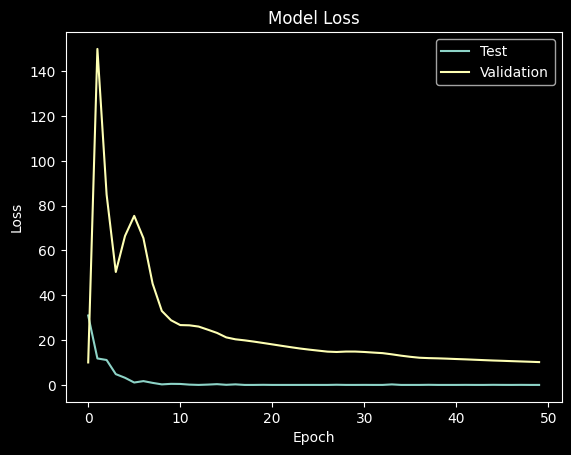

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Test', 'Validation'], loc='upper right')
plt.show()

# Just Checking the Model

In [ ]:
def names(number):
    if number==0:
        return 'Its a Tumor'
    else:
        return 'No, Its not a tumor'

No, Its not a tumor


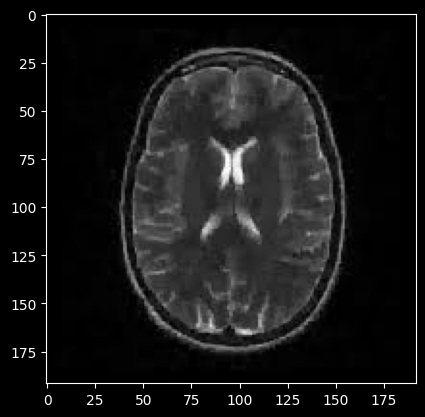

In [ ]:
from matplotlib.pyplot import imshow
img = Image.open(r"/content/drive/My Drive/MRI_IMAGES/brain_tumor_dataset/no/6 no.jpg")
x = np.array(img.resize((128,128)))
x = x.reshape(1,128,128,3)
res = model.predict_on_batch(x)
classification = np.where(res == np.amax(res))[1][0]
imshow(img)
print(names(classification))

Its a Tumor


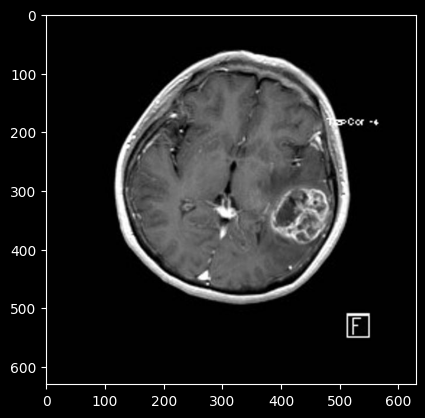

In [ ]:
from matplotlib.pyplot import imshow
img = Image.open(r"/content/drive/My Drive/MRI_IMAGES/brain_tumor_dataset/yes/Y29.jpg")
x = np.array(img.resize((128,128)))
x = x.reshape(1,128,128,3)
res = model.predict_on_batch(x)
classification = np.where(res == np.amax(res))[1][0]
imshow(img)
print(names(classification))